## Training PySpark Machine Learning Models on Full Training Set

This script was run on Microsoft Azure Databricks using Runtime Version 10.1.

In [0]:
spark

Out[1]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.2.0 
 Master 
 spark://10.139.64.5:7077 
 AppName 
 Databricks Shell

In [0]:
%sh
pip install --upgrade mlflow

Requirement already satisfied: mlflow in /databricks/python3/lib/python3.8/site-packages (1.23.1)
Requirement already satisfied: pytz in /databricks/python3/lib/python3.8/site-packages (from mlflow) (2020.5)
Requirement already satisfied: Flask in /databricks/python3/lib/python3.8/site-packages (from mlflow) (2.0.3)
Requirement already satisfied: sqlalchemy in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.4.31)
Requirement already satisfied: scipy in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.6.2)
Requirement already satisfied: alembic in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.7.6)
Requirement already satisfied: pandas in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.2.4)
Requirement already satisfied: sqlparse>=0.3.1 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.4.2)
Requirement already satisfied: gitpython>=2.1.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (3.1.27)
Requirement already satisfied: numpy in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.19.2)
Requirement already satisfied: databricks-cli>=0.8.7 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.16.4)
Requirement already satisfied: packaging in /databricks/python3/lib/python3.8/site-packages (from mlflow) (20.9)
Requirement already satisfied: protobuf>=3.7.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (3.17.2)
Requirement already satisfied: requests>=2.17.3 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (2.25.1)
Requirement already satisfied: cloudpickle in /databricks/python3/lib/python3.8/site-packages (from mlflow) (2.0.0)
Requirement already satisfied: click>=7.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (8.0.4)
Requirement already satisfied: gunicorn in /databricks/python3/lib/python3.8/site-packages (from mlflow) (20.1.0)
Requirement already satisfied: docker>=4.0.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (5.0.3)
Requirement already satisfied: querystring-parser in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.2.4)
Requirement already satisfied: pyyaml>=5.1 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (6.0)
Requirement already satisfied: importlib-metadata!=4.7.0,>=3.7.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (4.11.1)
Requirement already satisfied: entrypoints in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.3)
Requirement already satisfied: prometheus-flask-exporter in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.18.7)
Requirement already satisfied: six>=1.10.0 in /databricks/python3/lib/python3.8/site-packages (from databricks-cli>=0.8.7->mlflow) (1.15.0)
Requirement already satisfied: tabulate>=0.7.7 in /databricks/python3/lib/python3.8/site-packages (from databricks-cli>=0.8.7->mlflow) (0.8.9)
Requirement already satisfied: websocket-client>=0.32.0 in /databricks/python3/lib/python3.8/site-packages (from docker>=4.0.0->mlflow) (1.2.3)
Requirement already satisfied: gitdb<5,>=4.0.1 in /databricks/python3/lib/python3.8/site-packages (from gitpython>=2.1.0->mlflow) (4.0.9)
Requirement already satisfied: smmap<6,>=3.0.1 in /databricks/python3/lib/python3.8/site-packages (from gitdb<5,>=4.0.1->gitpython>=2.1.0->mlflow) (5.0.0)
Requirement already satisfied: zipp>=0.5 in /databricks/python3/lib/python3.8/site-packages (from importlib-metadata!=4.7.0,>=3.7.0->mlflow) (3.7.0)
Requirement already satisfied: certifi>=2017.4.17 in /databricks/python3/lib/python3.8/site-packages (from requests>=2.17.3->mlflow) (2020.12.5)
Requirement already satisfied: chardet<5,>=3.0.2 in /databricks/python3/lib/python3.8/site-packages (from requests>=2.17.3->mlflow) (4.0.0)
Requirement already satisfied: urllib3<1.27,>=1.21.1 in /databricks/python3/lib/python3.8/site-packages (from requests>=2.17.3->mlflow) (1.25.11)
Requirement a

In [0]:
import sys
#sys.path.append("Workspace/Repos/sparkify/sparkify-customer-retention")
sys.path.append("../src")
from sparkifychurn import cleanData, exploreData, generateFeatures, utils, trainModel, evaluateModel
import mlflow
import pyspark.sql.functions as F
import pandas as pd
pd.set_option("max.columns", None)
pd.set_option("max.rows", None)
import seaborn as sns
sns.set_theme()

## Read in Train/Test Data from DBFS

In [0]:
train = spark.read.parquet("dbfs:/FileStore/data/train_full")
test = spark.read.parquet("dbfs:/FileStore/data/test_full")

# To help with performance, we'll coalesce data down to one partition and cache the results
train = train.coalesce(1).cache()
test = test.coalesce(1).cache()

In [0]:
binary_features = ["paid", "submit_upgrade"]
cat_feature = "gender"
target_feature = "churn"
features_to_scale = list(set(train.columns) - set(["userId", *binary_features, cat_feature, target_feature]))

## Logistic Regression

This notebook uses mlflow to track model performance.

In [0]:
mlflow.pyspark.ml.autolog()

with mlflow.start_run():
    lr_cv_model = trainModel.train_lr_model(num_folds = 2, 
                                            train = train, 
                                            features_to_scale = features_to_scale, 
                                            binary_features = binary_features)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
2022/02/21 02:02:55 WARNING mlflow.utils: Truncated the value of the key `VectorAssembler_1.inputCols`. Truncated value: `['submit_downgrade_count', 'thumbs_up_pct', 'add_friend_rate', 'home_count', 'error_rate', 'non_song_interaction_count', 'avg_items_session', 'add_friend_count', 'about_rate', 'help_rate', 'avg_session_length_hours', 'downgrade_rate', 'avg_songs_s...`
2022/02/21 02:02:56 WARNING mlflow.utils: Truncated the value of the key `VectorAssembler_1.inputCols`. Truncated value: `['submit_downgrade_count', 'thumbs_up_pct', 'add_friend_rate', 'home_count', 'error_rate', 'non_song_interaction_count', 'avg_items_session', 'add_friend_count', 'about_rate', 'help_rate', 'avg_session_length_hours', 'downgrade_rate', 'avg_songs_s...`
2022/02/21 02:02:57 WARNING mlflow.utils: Truncated the value of the key `VectorAssembler_1.inputCols`. Truncated value: `['submit_downgrade_count', 'thumbs_up_pct', 'add_friend_rate', 'home_count', 'error_rate', 'non_song_interaction_count', 'avg_items_session', 'add_friend_count', 'about_rate', 'help_rate', 'avg_session_length_hours', 'downgrade_rate', 'avg_songs_s...`
2022/02/21 02:02:57 WARNING mlflow.utils: Truncated the value of the key `VectorAssembler_1.inputCols`. Truncated value: `['submit_downgrade_count', 'thumbs_up_pct', 'add_friend_rate', 'home_count', 'error_rate', 'non_song_interaction_count', 'avg_items_session', 'add_friend_count', 'about_rate', 'help_rate', 'avg_session_length_hours', 'downgrade_rate', 'avg_songs_s...`
2022/02/21 02:02:58 WARNING mlflow.utils: Truncated the value of the key `VectorAssembler_1.inputCols`. Truncated value: `['submit_downgrade_count', 'thumbs_up_pct', 'add_friend_rate', 'home_count', 'error_rate', 'non_song_interaction_count', 'avg_items_session', 'add_friend_count', 'about_rate', 'help_rate', 'avg_session_length_hours', 'downgrade_rate', 'avg_songs_s...`
2022/02/21 02:02:59 WARNING mlflow.utils: Truncated the value of the key `VectorAssembler_1.inputCols`. Truncated value: `['submit_downgrade_count', 'thumbs_up_pct', 'add_friend_rate', 'home_count', 'error_rate', 'non_song_interaction_count', 'avg_items_session', 'add_friend_count', 'about_rate', 'help_rate', 'avg_session_length_hours', 'downgrade_rate', 'avg_songs_s...`
2022/02/21 02:03:00 WARNING mlflow.utils: Truncated the value of the key `VectorAssembler_1.inputCols`. Truncated value: `['submit_downgrade_count', 'thumbs_up_pct', 'add_friend_rate', 'home_count', 'error_rate', 'non_song_interaction_count', 'avg_items_session', 'add_friend_count', 'about_rate', 'help_rate', 'avg_session_length_hours', 'downgrade_rate', 'avg_songs_s...`
2022/02/21 02:03:01 WARNING mlflow.utils: Truncated the value of the key `VectorAssembler_1.inputCols`. Truncated value: `['submit_downgrade_count', 'thumbs_up_pct', 'add_friend_rate', 'home_count', 'error_rate', 'non_song_interaction_count', 'avg_items_session', 'add_friend_count', 'about_rate', 'help_rate', 'avg_session_length_hours', 'downgrade_rate', 'avg_songs_s...`
2022/02/21 02:03:02 WARNING mlflow.utils: Truncated the value of the key `VectorAssembler_1.inputCols`. Truncated value: `['submit_downgrade_count', 'thumbs_up_pct', 'add_friend_rate', 'home_count', 'error_rate', 'non_song_interaction_count', 'avg_items_session', 'add_friend_count', 'about_rate', 'help_rate', 'avg_session_length_hours', 'downgrade_rate', 'avg_songs_s...`
2022/02/21 02:03:02 WARNING mlflow.utils: Truncated the value of the key `VectorAssembler_1.inputCols`. Truncated value: `['submit_downgrade_count', 'thumbs_up_pct', 'add_friend_rate', 'home_count', 'error_rate', 'non_song_interaction_count', 'avg_items_session', 'add_friend_count', 'about_rate', 'help_rate', 'avg_session_length_hours', 'downgrade_rate', 'avg_songs_s...`
2022/02/21 02:03:03 WARNING mlflow.utils: Truncated the value of the key `VectorAssembler_1.inputCols`. Truncated value: `['subm

In [0]:
# To access best model in mlfow:
lr_cv_model = mlflow.spark.load_model("dbfs:/databricks/mlflow-tracking/2169595321276221/68ee8d2f07664b3fa74ac2c809ad4c84/artifacts/best_model/")


In [0]:
# Create local directory in the file system to store output files. 
%fs mkdirs /FileStore/output/spark

Logistic_Regression - Train Set AUROC: 0.883
Logistic_Regression - Test Set AUROC: 0.879


Logistic_Regression - Train Average Precision: 0.698
Logistic_Regression - Test Average Precision: 0.688


Logistic_Regression - Train No Skill Precision: 0.223
Logistic_Regression - Test No Skill Precision: 0.228

 ****Classification Report on Train Data***
 precision recall f1-score support

 0 0.88 0.94 0.91 11995
 1 0.71 0.55 0.62 3443

 accuracy 0.85 15438
 macro avg 0.80 0.75 0.77 15438
weighted avg 0.84 0.85 0.84 15438


 ****Classification Report on Test Data***
 precision recall f1-score support

 0 0.88 0.94 0.91 5280
 1 0.72 0.56 0.63 1560

 accuracy 0.85 6840
 macro avg 0.80 0.75 0.77 6840
weighted avg 0.84 0.85 0.84 6840

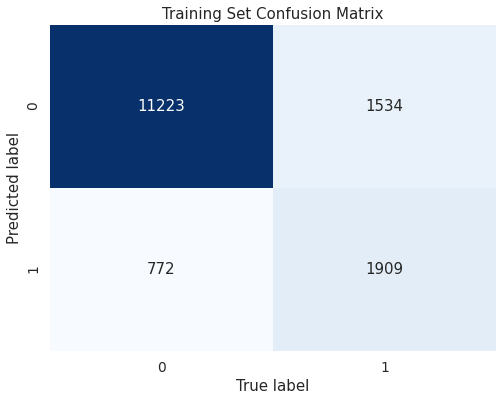

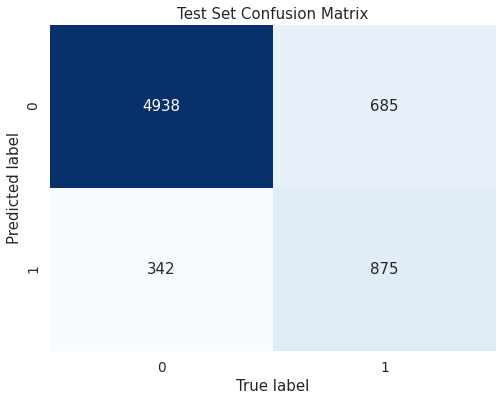

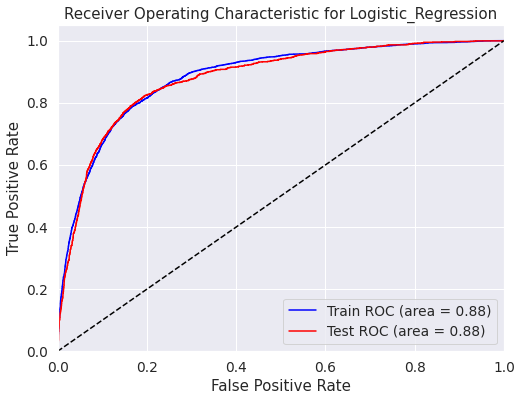

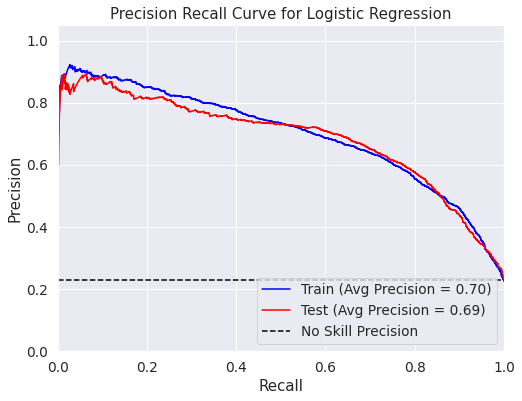

In [0]:
evaluateModel.evaluate_model(model = lr_cv_model,
                             model_type = "pyspark",
                             model_name = "Logistic_Regression",
                             output_path = "/dbfs/FileStore/output/spark",
                             train = train,
                             test = test)

## GBT Classifier

In [0]:
mlflow.pyspark.ml.autolog()

with mlflow.start_run():
    gbt_cv_model = trainModel.train_gbt_model(num_folds = 2, 
                                              train = train, 
                                              features_to_scale = features_to_scale, 
                                              binary_features = binary_features)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
2022/02/10 03:04:09 WARNING mlflow.utils: Truncated the value of the key `VectorAssembler_1.inputCols`. Truncated value: `['submit_downgrade_count', 'thumbs_up_pct', 'add_friend_rate', 'home_count', 'error_rate', 'non_song_interaction_count', 'avg_items_session', 'add_friend_count', 'about_rate', 'help_rate', 'avg_session_length_hours', 'downgrade_rate', 'avg_songs_s...`
2022/02/10 03:04:10 WARNING mlflow.utils: Truncated the value of the key `VectorAssembler_1.inputCols`. Truncated value: `['submit_downgrade_count', 'thumbs_up_pct', 'add_friend_rate', 'home_count', 'error_rate', 'non_song_interaction_count', 'avg_items_session', 'add_friend_count', 'about_rate', 'help_rate', 'avg_session_length_hours', 'downgrade_rate', 'avg_songs_s...`
2022/02/10 03:04:11 WARNING mlflow.utils: Truncated the value of the key `VectorAssembler_1.inputCols`. Truncated value: `['submit_downgrade_count', 'thumbs_up_pct', 'add_friend_rate', 'home_count', 'error_rate', 'non_song_interaction_count', 'avg_items_session', 'add_friend_count', 'about_rate', 'help_rate', 'avg_session_length_hours', 'downgrade_rate', 'avg_songs_s...`
2022/02/10 03:04:12 WARNING mlflow.utils: Truncated the value of the key `VectorAssembler_1.inputCols`. Truncated value: `['submit_downgrade_count', 'thumbs_up_pct', 'add_friend_rate', 'home_count', 'error_rate', 'non_song_interaction_count', 'avg_items_session', 'add_friend_count', 'about_rate', 'help_rate', 'avg_session_length_hours', 'downgrade_rate', 'avg_songs_s...`
2022/02/10 03:04:13 WARNING mlflow.utils: Truncated the value of the key `VectorAssembler_1.inputCols`. Truncated value: `['submit_downgrade_count', 'thumbs_up_pct', 'add_friend_rate', 'home_count', 'error_rate', 'non_song_interaction_count', 'avg_items_session', 'add_friend_count', 'about_rate', 'help_rate', 'avg_session_length_hours', 'downgrade_rate', 'avg_songs_s...`
2022/02/10 03:04:14 WARNING mlflow.utils: Truncated the value of the key `VectorAssembler_1.inputCols`. Truncated value: `['submit_downgrade_count', 'thumbs_up_pct', 'add_friend_rate', 'home_count', 'error_rate', 'non_song_interaction_count', 'avg_items_session', 'add_friend_count', 'about_rate', 'help_rate', 'avg_session_length_hours', 'downgrade_rate', 'avg_songs_s...`
2022/02/10 03:04:15 WARNING mlflow.utils: Truncated the value of the key `VectorAssembler_1.inputCols`. Truncated value: `['submit_downgrade_count', 'thumbs_up_pct', 'add_friend_rate', 'home_count', 'error_rate', 'non_song_interaction_count', 'avg_items_session', 'add_friend_count', 'about_rate', 'help_rate', 'avg_session_length_hours', 'downgrade_rate', 'avg_songs_s...`
2022/02/10 03:04:16 WARNING mlflow.utils: Truncated the value of the key `VectorAssembler_1.inputCols`. Truncated value: `['submit_downgrade_count', 'thumbs_up_pct', 'add_friend_rate', 'home_count', 'error_rate', 'non_song_interaction_count', 'avg_items_session', 'add_friend_count', 'about_rate', 'help_rate', 'avg_session_length_hours', 'downgrade_rate', 'avg_songs_s...`
2022/02/10 03:04:16 WARNING mlflow.utils: Truncated the value of the key `VectorAssembler_1.inputCols`. Truncated value: `['submit_downgrade_count', 'thumbs_up_pct', 'add_friend_rate', 'home_count', 'error_rate', 'non_song_interaction_count', 'avg_items_session', 'add_friend_count', 'about_rate', 'help_rate', 'avg_session_length_hours', 'downgrade_rate', 'avg_songs_s...`

In [0]:
gbt_cv_model = mlflow.spark.load_model("dbfs:/databricks/mlflow-tracking/2169595321276221/024db7bc715c4fb39e643f9b0657a51f/artifacts/best_model")

GBT_Classifier - Train Set AUROC: 0.925
GBT_Classifier - Test Set AUROC: 0.917


GBT_Classifier - Train Average Precision: 0.837
GBT_Classifier - Test Average Precision: 0.823


GBT_Classifier - Train No Skill Precision: 0.223
GBT_Classifier - Test No Skill Precision: 0.228

 ****Classification Report on Train Data***
 precision recall f1-score support

 0 0.90 0.97 0.93 11995
 1 0.84 0.65 0.73 3443

 accuracy 0.89 15438
 macro avg 0.87 0.81 0.83 15438
weighted avg 0.89 0.89 0.89 15438


 ****Classification Report on Test Data***
 precision recall f1-score support

 0 0.90 0.96 0.93 5280
 1 0.82 0.65 0.73 1560

 accuracy 0.89 6840
 macro avg 0.86 0.81 0.83 6840
weighted avg 0.89 0.89 0.88 6840

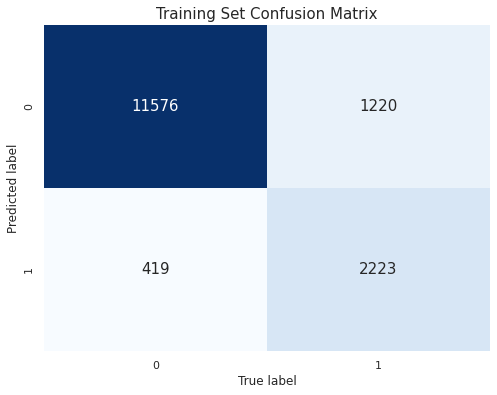

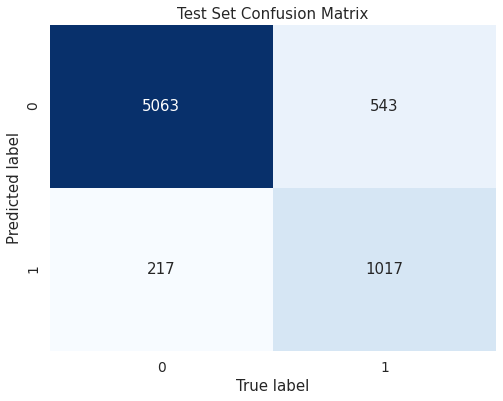

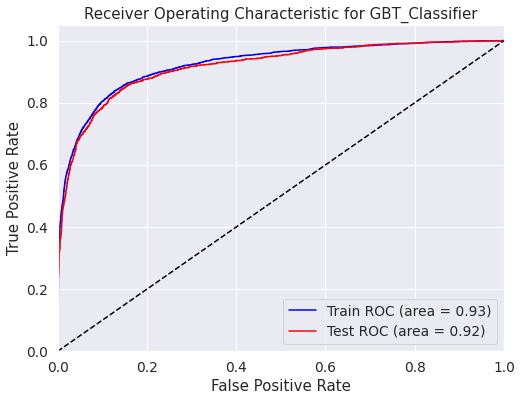

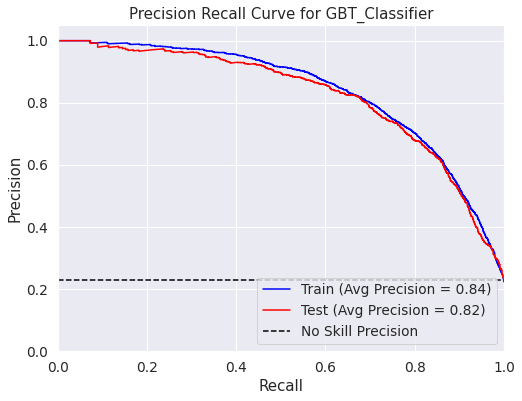

In [0]:
evaluateModel.evaluate_model(model = gbt_cv_model,
                             model_type = "pyspark",
                             model_name = "GBT_Classifier",
                             output_path = "/dbfs/FileStore/output/spark",
                             train = train,
                             test = test)